Teilweise orientiert an [*Introduction to Machine Learning with Python* von Andreas C. Müller, Sarah Guido](https://www.oreilly.com/library/view/introduction-to-machine/9781449369880/).

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Lineare Modelle und Regularisierung
Lineare Modelle sind besonders geeignet, wenn

- wenig Daten verfügbar sind oder
- die Daten sehr hochdimensional sind (d.h. sehr viele Features).

Außerdem kann damit das Konzept der **Regularisierung** sehr gut studiert werden. Unter Regularisierung versteht man **alle Maßnahmen**, die darauf abzielen, den **Generalisierungsfehler zu verringern**.


# Lineare Modelle für Regression
Alle linearen Regressionsmodelle lernen die Parameter ``coef_`` und ``intercept_`` und erzeugen daraus die Linearkombination (eigentlich affin-linear)
```
y_pred = x_test[0] * coef_[0] + ... + x_test[n_features-1] * coef_[n_features-1] + intercept_
```
Die unterschiedlichen linearen Modelle unterscheiden sich nur darin, welche Einschränkungen und/oder Bestrafungen für die Koeffizienten gelten.

Einfachster Fall: *Ordinary least squares regression*, auch genannt *lineare Regression*. Bei diesem Modell gibt es keinerlei Einschränkungen an die Koeffizienten. Nachteil: Wenn die Anzahl der Features groß ist, wird das Problem schlecht konditioniert, was zu Overfitting führt.

Wir generieren ein 30-dimensionales Datenset. Dazu verwenden wir die Funktion ``make_regression``, die uns viel Kontrolle gibt:
- Anzahl der Daten
- Anzahl der Features
- Anzahl der *wichtigen* Features
- Rauschen
- Korrekte Koeffizienten der nachträglich verrauschten Daten

In [3]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y, true_coefficient = make_regression(n_samples=200, n_features=30, n_informative=10, noise=100, coef=True, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, train_size=60, test_size=140)
print(X_train.shape)
print(y_train.shape)

(60, 30)
(60,)


## Lineare Regression
Ziel: Finde die Koeffizienten $w$ und $b$, so dass
$$ \sum_i || w^\mathsf{T}x_i + b  - y_i||^2 \longrightarrow \text{min}$$

Nun trainieren wir ein ``LinearRegression`` Modell und bewerten dieses ($R^2$-Score):

In [4]:
from sklearn.linear_model import LinearRegression
linear_regression = LinearRegression().fit(X_train, y_train)
print("R^2 auf Trainingsdaten: %f" % linear_regression.score(X_train, y_train))
print("R^2 auf Testdaten: %f" % linear_regression.score(X_test, y_test))

R^2 auf Trainingsdaten: 0.878011
R^2 auf Testdaten: 0.216332


Das sieht nach Overfitting aus. Zum Vergleich prüfen wir, welche $R^2$-Score die "korrekten" Koeffizienten ergeben würden (diese kennen wir von oben aus der Erzeugung der Daten).

In [5]:
from sklearn.metrics import r2_score
print(r2_score(np.dot(X, true_coefficient), y))

0.5985284495875146


Damit ist der Fall klar: Overfitting (denn die Score auf den Trainingsdaten ist besser als die der korrekten Koeffizienten; somit hat das Modell auch das Rauschen gelernt.)

Wir wollen nun die 30 Koeffizienten betrachten (grafische Darstellung, sortiert nach absteigender Größe):

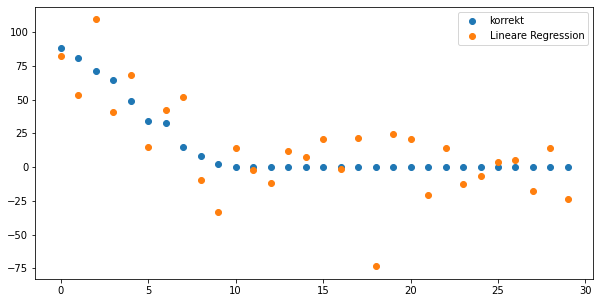

In [6]:
plt.figure(figsize=(10, 5))
coefficient_sorting = np.argsort(true_coefficient)[::-1]
plt.plot(true_coefficient[coefficient_sorting], "o", label="korrekt")
plt.plot(linear_regression.coef_[coefficient_sorting], "o", label="Lineare Regression")

plt.legend();

Wir hatten oben bei der Datenerzeugung gewählt, dass nur 10 Koeffizienten wirklich wichtig sein sollen (die 20 restlichen sind demnach 0). Das Modell lernt das *nicht*.

Wir betrachten die Lern-Kurve:

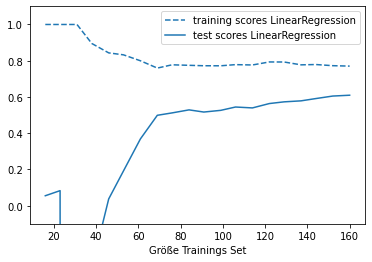

In [7]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(est, X, y):
    training_set_size, train_scores, test_scores = learning_curve(est, X, y, train_sizes=np.linspace(.1, 1, 20))
    estimator_name = est.__class__.__name__
    line = plt.plot(training_set_size, train_scores.mean(axis=1), '--', label="training scores " + estimator_name)
    plt.plot(training_set_size, test_scores.mean(axis=1), '-', label="test scores " + estimator_name, c=line[0].get_color())
    plt.xlabel('Größe Trainings Set')
    plt.legend(loc='best')
    plt.ylim(-0.1, 1.1)

plt.figure()    
plot_learning_curve(LinearRegression(), X, y)

## $L^2$-Strafe, Ridge Regression, Tikhonov Regularisierung
In obigem Beispiel konnte nur deshalb auch das Rauschen gelernt werden, weil das Modell 30 Koeffizienten wählen konnte obwohl die echten Daten eigentlich von nur 10 Koeffizienten gestützt wurden. Daher kommt die Idee, dass man als weiteres Ziel auch möchte, dass es nicht "zu viele große Koeffizienten" gibt.
Um das zu erreichen, wird die zu optimierende Funktion angepasst.

Neues Ziel: Finde die Koeffizienten $w$ und $b$, so dass

$$ \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_2^2 \longrightarrow \text{min}$$
Wie stark oder schwach die "Größe" des Koeffizientenvektors $w$ eingeht, wird über den Parameter ``alpha`` besteuert. Um herauszufinden, welcher Wert für die vorliegenden Daten geeignet ist, probieren wir durch:

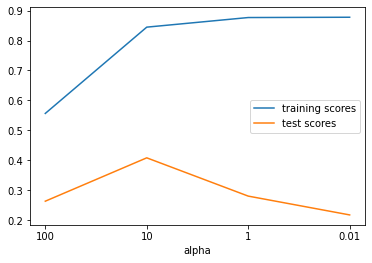

In [8]:
from sklearn.linear_model import Ridge
ridge_models = {}
training_scores = []
test_scores = []

for alpha in [100, 10, 1, .01]:
    ridge = Ridge(alpha=alpha).fit(X_train, y_train)
    training_scores.append(ridge.score(X_train, y_train))
    test_scores.append(ridge.score(X_test, y_test))
    ridge_models[alpha] = ridge

plt.figure()
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(4), [100, 10, 1, .01])
plt.xlabel('alpha')
plt.legend(loc="best");

Wir betrachten die Koeffizienten wie oben:

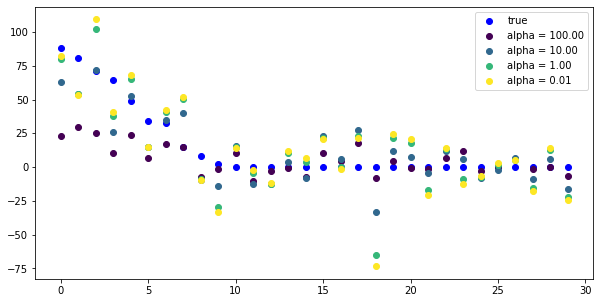

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(true_coefficient[coefficient_sorting], "o", label="true", c='b')

for i, alpha in enumerate([100, 10, 1, .01]):
    plt.plot(ridge_models[alpha].coef_[coefficient_sorting], "o", label="alpha = %.2f" % alpha, c=plt.cm.viridis(i / 3.))
    
plt.legend(loc="best")

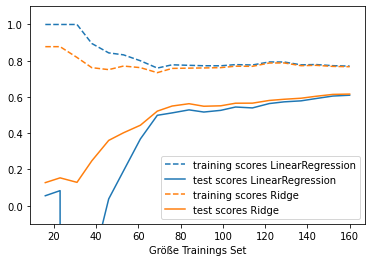

In [10]:
plt.figure()
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=10), X, y)

## $L^1$-Strafe, "Lasso"

Der sog. **Lasso** Estimator hat zum Ziel, möglichst viele Koeffizienten auf Null zu setzen. Dies ist sinnvoll, wenn man (wie in diesem Beispiel) davon ausgeht, dass viele Features nicht relevant sind. Realisiert wird das analog zum $L^2$-Fall durch eine Abänderung der zu optimierenden Größe.

Neues Ziel: Finde die Koeffizienten $w$ und $b$, so dass

$$ \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + \alpha ||w||_1 \longrightarrow \text{min}$$
Auch hier regelt der Parameter ``alpha`` die Gewichtung der beiden Ziele "approximiere die Daten gut" und "erzeuge möglichst viele Nuller bei den Koeffizienten".

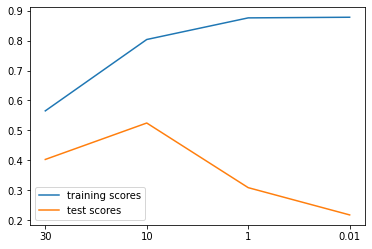

In [11]:
from sklearn.linear_model import Lasso

lasso_models = {}
training_scores = []
test_scores = []

for alpha in [30, 10, 1, .01]:
    lasso = Lasso(alpha=alpha).fit(X_train, y_train)
    training_scores.append(lasso.score(X_train, y_train))
    test_scores.append(lasso.score(X_test, y_test))
    lasso_models[alpha] = lasso
plt.figure()
plt.plot(training_scores, label="training scores")
plt.plot(test_scores, label="test scores")
plt.xticks(range(4), [30, 10, 1, .01])
plt.legend(loc="best")

Auch hier betrachten wir wieder die Koeffizienten:

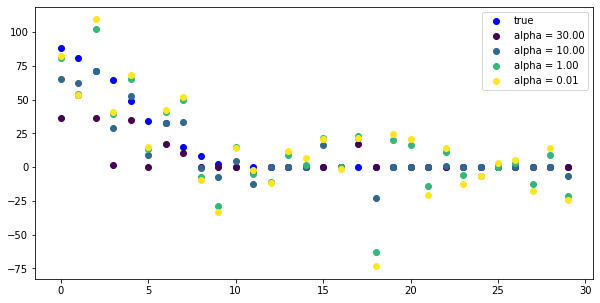

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(true_coefficient[coefficient_sorting], "o", label="true", c='b')

for i, alpha in enumerate([30, 10, 1, .01]):
    plt.plot(lasso_models[alpha].coef_[coefficient_sorting], "o", label="alpha = %.2f" % alpha, c=plt.cm.viridis(i / 3.))
    
plt.legend(loc="best")

Wir betrachten die Lernkurven für die drei Modelle
- lineare Regression (ohne Regularisierung)
- Ridge ($L^2$-Regularisierung)
- Lasso ($L^1$-Regularisierung)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70.53520064219992, tolerance: 49.5759437095842
  positive)


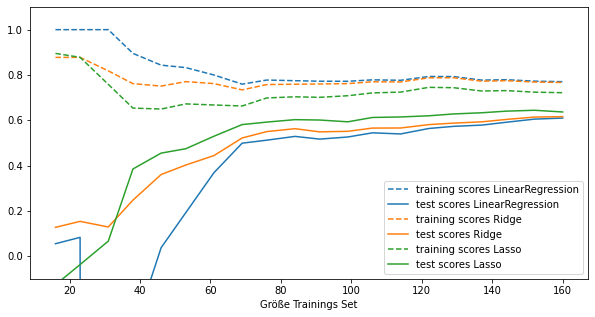

In [13]:
plt.figure(figsize=(10, 5))
plot_learning_curve(LinearRegression(), X, y)
plot_learning_curve(Ridge(alpha=10), X, y)
plot_learning_curve(Lasso(alpha=10), X, y)

Neben Ridge und Lasso (oder besser: zwischen den beiden) gibt es noch ``ElasticNet``, welches eine Mischung beider Regularisierungen darstellt.

$$ \sum_i || w^\mathsf{T}x_i + b  - y_i||^2  + r \alpha ||w||_1 + \frac{1-r}{2}\alpha ||w||_2^2 \longrightarrow \text{min}$$

# Lineare Modelle zur Klassifizierung

Wie bei der Regression lernen lineare Modelle auch bei der Klassifizierung die Parameter ``coef_`` und ``intercept_`` und entscheiden anhand der Linearkombination (eigentlich affin-linear)
```
y_pred = x_test[0] * coef_[0] + ... + x_test[n_features-1] * coef_[n_features-1] + intercept_ > 0
```

Das ist nahezu identisch mit linearer Regression. Es wird lediglich der Wert der Linearkombination mit 0 verglichen. Diejenigen "x" mit positivem Wert kommen in die eine Kategorie, die mit nicht-positivem Wert in die andere.

Auch hier gibt es wieder unterschiedlich Modelle, die sich v.a. durch die Art der Regularisierung unterscheiden. Auch die Bewertung, wie gut das Modell zu den Daten passt, unterscheidet sich geringfügig.

Bei linearen Klassifizierern kann man sich *Regularisierung* grob so vorstellen:
- Starke Regularisierung: es reicht, wenn die meisten Punkte korrekt klassifiziert werden
- Schwache Regularisierung: jeder einzelne Punkt ist wichtig.

Um dies zu veranschaulichen, verwenden wir eine lineare Support Vector Machine, der Regularisierungsparameter heißt dort ``C``:
- niedriger Wert von ``C``: stärker regularisiert, einfacheres Modell
- höherer  Wert von ``C``: schwächer regularisiert, komplexeres Modell


     |████████████████████████████████| 542kB 6.2MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582639 sha256=e963259a7b4929b8ec3b148b4a0c069b4d9a3a67206127f1950068eee8526501
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


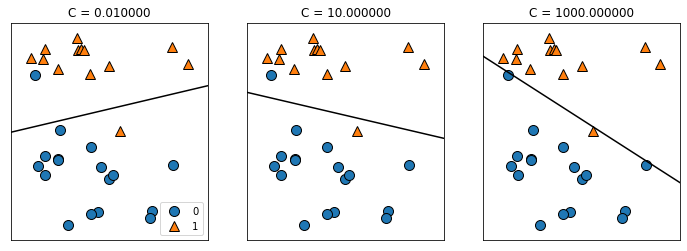

In [14]:
!pip install mglearn
import mglearn
mglearn.plots.plot_linear_svc_regularization()

 # Lineare multi-class Klassifizierung
 Natürlich kann es auch mehr als zwei Klassen geben:

<Figure size 432x288 with 0 Axes>

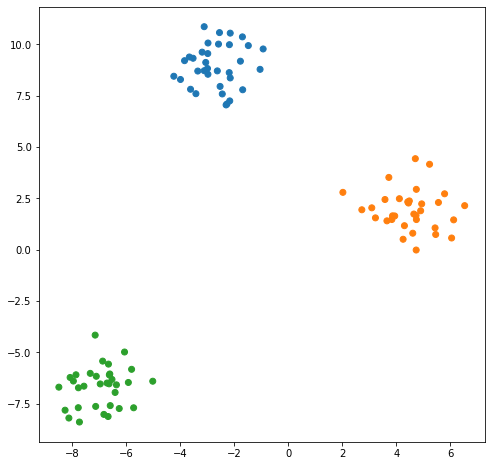

In [15]:
from sklearn.datasets import make_blobs
plt.figure()
X, y = make_blobs(random_state=42)
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y));

Wir verwenden eine LinearSVM zur Klassifizierung. Diese lernt wieder die Parameter ``coef_`` und ``intercept_``:

In [16]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)
print(linear_svm.coef_.shape)
print(linear_svm.intercept_.shape)

(3, 2)
(3,)


In [17]:
linear_svm.coef_

array([[-0.17492582,  0.23141112],
       [ 0.47621901, -0.06936525],
       [-0.18914548, -0.20399702]])

In [18]:
linear_svm.intercept_

array([-1.07745558,  0.13140743, -0.08604894])

Die Multi-Class-Klassifizierung geht bei LinearSVC nach dem Prinzip "one vs. all", d.h. es werden hier drei Modelle trainiert:
- "grün/nicht-grün"
- "blau/nicht-blau"
- "orange/nicht-orange"

Bei SVM geht es darum, eine separierende Gerade zu finden, die möglichst großen Abstand zu den Punkten hat ("margin"). Diese sind unten für die drei Modelle gezeichnet.

Um nun einen Punkt zu klassifizieren, wird er anhand aller (hier: drei) Modelle bewertet. Das Modell, das dem Punkt die höchste Bewertung zuweist, gewinnt und ordnet den Punkt in "seine" Kategorie ein. Eine hohe Bewertung heißt dabei: großer Abstand zur separierenden Geraden (auf der richtigen Seite).

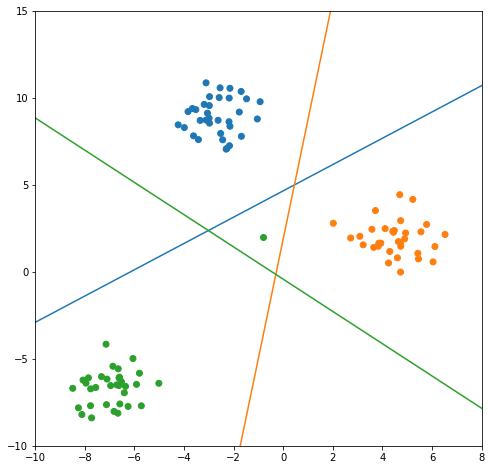

In [142]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y))
line = np.linspace(-15, 15)
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1])
plt.ylim(-10, 15)
plt.xlim(-10, 8)

# Klassifizierung eines beliebigen Punktes (durch linear_svm.predict([pt]) wird das Label 0,1,2 bestimmt, dieses legt dann die Farbe fest)
pt = [-.8,2]
plt.scatter(pt[0],pt[1], color=plt.cm.tab10(linear_svm.predict([pt])[0]))

## Darstellung der Winkelhalbierenden

In [20]:
import numpy as np

In [132]:
def bisectrix(a, b):
  n1 = np.sign(a[0])*np.array([a[1], -a[0]])/np.sqrt(a[1]**2 + a[0]**2)
  n2 = np.sign(b[0])*np.array([b[1], -b[0]])/np.sqrt(b[1]**2 + b[0]**2)
  m = n1+n2
  m = m/np.linalg.norm(m)

  A = np.array([[a[0],a[1]], [b[0], b[1]]])
  rhs = -np.array([a[2], b[2]])
  intersection = np.linalg.solve(A,rhs)

  return m, intersection

In [154]:
(i,j) = (1,2)
a = np.append(linear_svm.coef_[i], linear_svm.intercept_[i])
b = np.append(linear_svm.coef_[j], linear_svm.intercept_[j])
m, intersection = bisectrix(a,b)

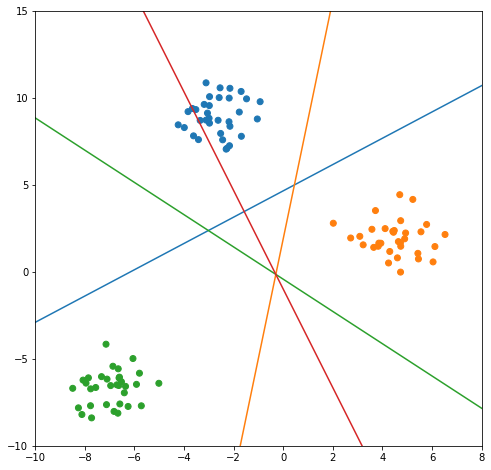

In [155]:
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=plt.cm.tab10(y))
line = np.linspace(-15, 15)
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):
    plt.plot(line, -(line * coef[0] + intercept) / coef[1])
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.plot(line, m[1]/m[0]*(line-intersection[0]) + intersection[1])